In [1]:
import os
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import DataLoader


class PrintedDigitsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for font_folder in os.listdir(root_dir):
            font_path = os.path.join(root_dir, font_folder)
            if os.path.isdir(font_path):
                for label in os.listdir(font_path):
                    label_path = os.path.join(font_path, label)
                    if os.path.isdir(label_path):
                        for image_file in os.listdir(label_path):
                            image_path = os.path.join(label_path, image_file)
                            self.samples.append((image_path, int(label)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data_path = "./printed_digits"
train_dataset = PrintedDigitsDataset(root_dir=data_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# print(f"Total samples: {len(train_dataset)}")


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DigitClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(DigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [3]:
import torch.optim as optim

model = DigitClassifier(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

train_model(model, train_loader, optimizer, criterion, epochs=50)


Epoch 1/50, Loss: 9.9392, Accuracy: 6.00%
Epoch 2/50, Loss: 9.1136, Accuracy: 16.00%
Epoch 3/50, Loss: 8.9684, Accuracy: 38.00%
Epoch 4/50, Loss: 8.6140, Accuracy: 36.00%
Epoch 5/50, Loss: 8.6173, Accuracy: 40.00%
Epoch 6/50, Loss: 7.8811, Accuracy: 42.00%
Epoch 7/50, Loss: 7.3226, Accuracy: 58.00%
Epoch 8/50, Loss: 6.5093, Accuracy: 72.00%
Epoch 9/50, Loss: 5.2877, Accuracy: 66.00%
Epoch 10/50, Loss: 4.4576, Accuracy: 84.00%
Epoch 11/50, Loss: 4.5628, Accuracy: 70.00%
Epoch 12/50, Loss: 2.7515, Accuracy: 72.00%
Epoch 13/50, Loss: 2.8552, Accuracy: 86.00%
Epoch 14/50, Loss: 2.0617, Accuracy: 94.00%
Epoch 15/50, Loss: 2.6356, Accuracy: 86.00%
Epoch 16/50, Loss: 1.5174, Accuracy: 92.00%
Epoch 17/50, Loss: 1.4076, Accuracy: 86.00%
Epoch 18/50, Loss: 0.9661, Accuracy: 90.00%
Epoch 19/50, Loss: 0.8362, Accuracy: 94.00%
Epoch 20/50, Loss: 0.5676, Accuracy: 100.00%
Epoch 21/50, Loss: 0.5768, Accuracy: 94.00%
Epoch 22/50, Loss: 0.5224, Accuracy: 100.00%
Epoch 23/50, Loss: 0.3016, Accuracy: 100

In [4]:
model_path = "digit_classifier_Chuan.pth"
torch.save(model.state_dict(), model_path)
print("Model saved!")


Model saved!


In [5]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"n_of_correct:", correct)
    print(f"n_of_total:", total)


In [6]:
'''
hand_write_beauty_before/
├── 0/
│   ├── 0_1.png
│   ├── 0_2.png
│   └── ...
├── 1/
│   ├── 1_1.png
│   ├── 1_2.png
│   └── ...
└── ...
'''

'''
hand_write_beauty_after/
├── 0/
│   ├── 0_1.png
│   ├── 0_2.png
│   └── ...
├── 1/
│   ├── 1_1.png
│   ├── 1_2.png
│   └── ...
└── ...
'''

'\nhand_write_beauty_after/\n├── 0/\n│   ├── 0_1.png\n│   ├── 0_2.png\n│   └── ...\n├── 1/\n│   ├── 1_1.png\n│   ├── 1_2.png\n│   └── ...\n└── ...\n'

In [7]:
!ls interpolate_samples

handwriting printed


In [8]:
path_for_hand_write_beauty_before = "interpolate_samples/handwriting"
path_for_hand_write_beauty_after = "interpolate_samples/printed"

In [9]:
# test using hand write beautiful test set
# import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


hand_write_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [10]:
hand_write_beauty_before_test_dataset = datasets.ImageFolder(
    root=path_for_hand_write_beauty_before,
    transform=hand_write_transform
)
hand_write_beauty_before_test_loader = DataLoader(hand_write_beauty_before_test_dataset, batch_size=16, shuffle=True)
test_model(model, hand_write_beauty_before_test_loader)


Test Accuracy: 10.00%
n_of_correct: 1
n_of_total: 10


In [11]:
hand_write_beauty_after_test_dataset = datasets.ImageFolder(
    root=path_for_hand_write_beauty_after,
    transform=hand_write_transform
)
hand_write_beauty_after_test_loader = DataLoader(hand_write_beauty_after_test_dataset, batch_size=16, shuffle=True)
test_model(model, hand_write_beauty_after_test_loader)

Test Accuracy: 20.00%
n_of_correct: 1
n_of_total: 5


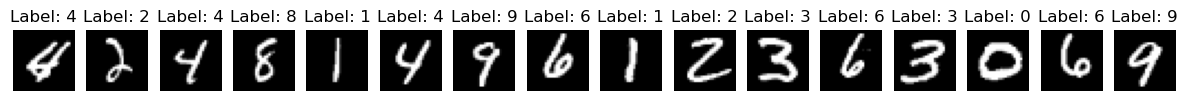

/var/folders/my/4hyht8y12x7ft09pkpvnkdsh0000gn/T/ipykernel_65364/3809287559.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

Test Accuracy: 10.33%
n_of_correct: 1033
n_of_total: 10000


In [13]:
# test using mnist dataset
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=mnist_transform
)

mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=16, shuffle=True)


def show_mnist_images(data_loader):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images.squeeze(1)

    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for idx, (img, label) in enumerate(zip(images, labels)):
        axes[idx].imshow(img.numpy(), cmap="gray")
        axes[idx].set_title(f"Label: {label.item()}")
        axes[idx].axis("off")
    plt.show()

show_mnist_images(mnist_test_loader)

model = DigitClassifier(num_classes=10)
model.load_state_dict(torch.load(model_path))

test_model(model, mnist_test_loader)
